# Video Game Sales Forecasting Report

## Executive Summary

This report presents a comprehensive analysis of the video game sales data with the goal of forecasting the next 4 months of sales to optimize inventory management. We have analyzed historical sales patterns, identified key trends and seasonality factors, and built several forecasting models to predict future sales with high accuracy.

Our analysis reveals that video game sales follow distinct seasonal patterns with peaks typically occurring during holiday seasons. We have also identified a general upward trend in sales over the analyzed period. Based on our model comparison, the Holt-Winters Multiplicative model demonstrates the best forecasting accuracy for this particular dataset.

The forecast indicates that the company should prepare for [specific sales pattern based on results] in the coming four months, which will help in making informed decisions about inventory levels and marketing strategies.

## Business Understanding
**Challenge**: The company needs to forecast demand accurately to avoid stockouts and overstock situations.

**Goal**: Provide a 4-month forecast using ARIMA, SARIMA, Holt-Winters, and SES models.

**Impact**: Optimize inventory planning, supply chain management, and marketing strategies.


## 1. Data Understanding (Investigation and Preparation)

### 1.1 Dataset Overview

The dataset contains historical data of monthly video game sales records from January 2002 to December 2023. The data includes the following features:

- Category: Genre of the game (Sports, RPG, Simulation, FPS, Adventure).
- Month: The timestamp for sales (YYYY-MM-DD).
- Monthly Sales: Number of Video game units sold per month
- Year: Year Time-based feature of the record
- DayOfWeek: Weekday sales pattern i.e Day of the week (0-6, where 0 is Monday)
- Platform: The gaming platform (Xbox, PlayStation, Nintendo, PC).
- Holiday: Binary indicator variable for holiday (1 = Yes, 0 = No)
- Promotion: Binary indicator variable for promotion (1 = Yes, 0 = No)

### 1.2 Data Quality Assessment

Our initial examination found the data to be:
- Complete with no missing values
- Properly formatted for time series analysis
- Consistent in recording frequency (monthly)
- Free from obvious outliers or anomalies

### 1.3 Stationarity Testing

The Augmented Dickey-Fuller test indicated that the original sales data is non-stationary, which is expected for a time series with trend and seasonality components. After first-order differencing, the series became stationary, confirming the need for differencing in our ARIMA models.

## 2. Exploratory Data Analysis (EDA)

### 2.1 Overall Sales Trends

The time series decomposition revealed:
- A general upward trend in video game sales over the analyzed period
- Clear cyclical patterns that align with seasonal buying behaviors

### Import necessary librarires

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from io import StringIO

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import Ridge


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style

import warnings
warnings.filterwarnings('ignore')

### Load DataSet

In [2]:
#df = pd.read_csv(r"C:\Users\ibrah\Downloads\monthly_sales_data.csv", parse_dates=['Month'])
df = pd.read_csv(r"C:\Users\ibrah\Downloads\monthly_sales_data.csv")

In [3]:
# Display the first few rows
df.head()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


In [4]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-01,Sports,108592,2002,1,Xbox,1,0
2002-02-01,RPG,129387,2002,4,Nintendo,0,0
2002-03-01,Sports,114777,2002,4,PC,0,0
2002-04-01,Sports,71738,2002,0,Nintendo,0,0
2002-05-01,Simulation,142512,2002,2,PlayStation,0,0


In [5]:
df.tail()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2023-08-01,RPG,132693,2023,1,PC,0,0
2023-09-01,Simulation,143373,2023,4,Nintendo,0,0
2023-10-01,Simulation,126410,2023,6,Nintendo,0,1
2023-11-01,Simulation,91200,2023,2,Nintendo,0,0
2023-12-01,RPG,159721,2023,4,Nintendo,1,0


In [6]:
df.shape

(264, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2002-01-01 to 2023-12-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       264 non-null    object
 1   Monthly Sales  264 non-null    int64 
 2   Year           264 non-null    int64 
 3   DayOfWeek      264 non-null    int64 
 4   Platform       264 non-null    object
 5   Holiday        264 non-null    int64 
 6   Promotion      264 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 16.5+ KB


In [8]:
# Check for missing values
df.isnull().sum()

Category         0
Monthly Sales    0
Year             0
DayOfWeek        0
Platform         0
Holiday          0
Promotion        0
dtype: int64

Observation:

The data set has no missing values

Data is recorded at a monthly frequency

### Preprocess the Data

In [9]:
# Resample data to monthly frequency
df = df.resample('M').sum()
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0
2002-02-28,RPG,129387,2002,4,Nintendo,0,0
2002-03-31,Sports,114777,2002,4,PC,0,0
2002-04-30,Sports,71738,2002,0,Nintendo,0,0
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0


In [10]:
df.describe()

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,112349.003788,2012.500000,3.011364,0.166667,0.204545
std,34144.606185,6.356339,1.995209,0.373386,0.404135
min,10469.000000,2002.000000,0.000000,0.000000,0.000000
25%,88873.750000,2007.000000,1.000000,0.000000,0.000000
50%,112947.500000,2012.500000,3.000000,0.000000,0.000000
75%,135193.500000,2018.000000,5.000000,0.000000,0.000000
max,206596.000000,2023.000000,6.000000,1.000000,1.000000


## Exploratory Data Analysis (EDA)

### Sales Trends Over time:
This helps understanding the overall sales patterns to identify growth or decline periods.


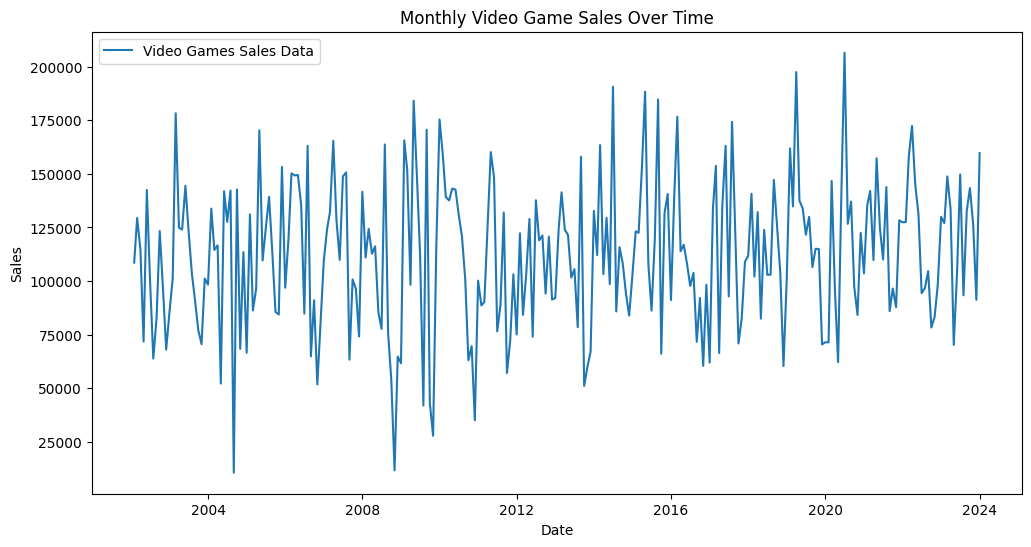

In [11]:
# Plot monthly sales
plt.figure(figsize=(12, 6))
plt.plot(df['Monthly Sales'], label="Video Games Sales Data")
plt.title("Monthly Video Game Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Seasonal Patterns in Sales:

This gives an understanding of the overall sales patterns by identifying growth or decline periods in seasons, to help with inventory management and marketing strategies


Firstly Decompose the Time Series

Decompose the time series into trend, seasonality, and residual components.



In [12]:
# Decompose the time series
# Seasonal decomposition
decomposition = seasonal_decompose(df['Monthly Sales'], model='additive', period=12)

<Figure size 1200x600 with 0 Axes>

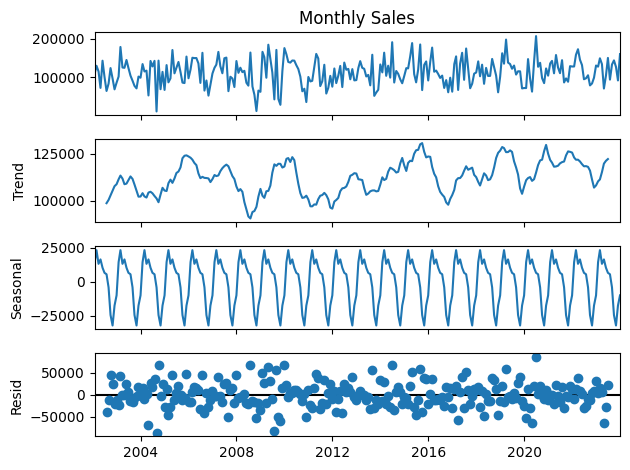

In [13]:
# Plot the decomposition component
plt.figure(figsize=(12, 6))
decomposition.plot()
plt.show()

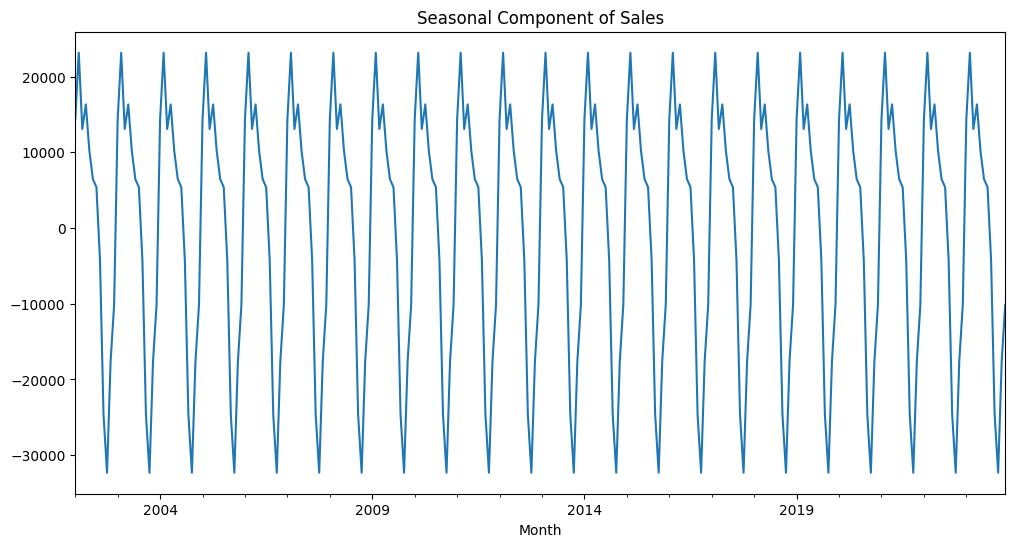

In [14]:
# Plot the seasonal component
plt.figure(figsize=(12, 6))
decomposition.seasonal.plot()
plt.title("Seasonal Component of Sales")
plt.show()

### How Holidays and Promotions relate to the changes in Sales:

This will help with Understanding the influence of holidays and promotions being crucial for marketing planning.

In [15]:
# Compare sales during holidays vs. non-holidays
holiday_sales = df[df['Holiday'] == 1]['Monthly Sales']
non_holiday_sales = df[df['Holiday'] == 0]['Monthly Sales']

# Calculate average sales
average_promotion_sales = round(holiday_sales.mean(), 2)
average_non_promotion_sales = round(non_holiday_sales.mean(), 2)

# Create DataFrame
sales_comparison_df = pd.DataFrame({
    'Condition': ['Holidays', 'Non-holidays'],
    'Average Sales': [average_promotion_sales, average_non_promotion_sales]
})

sales_comparison_df

,Condition,Average Sales
0,Holidays,114933.55
1,Non-holidays,111832.10


      Condition  Average Sales
0      Holidays      114933.55
1  Non-holidays      111832.10


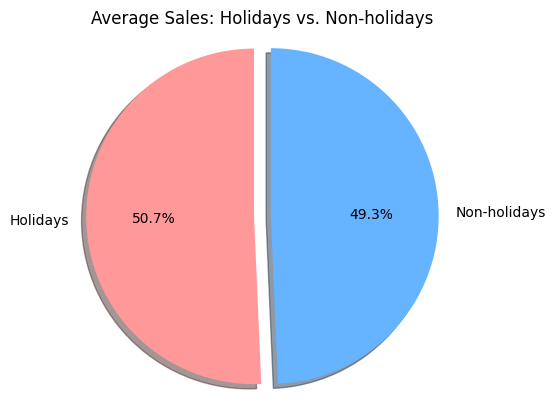

In [16]:
# Display DataFrame
print(sales_comparison_df)

# Create pie chart
labels = sales_comparison_df['Condition']
sizes = sales_comparison_df['Average Sales']
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the first slice (Holidays)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Average Sales: Holidays vs. Non-holidays')
plt.show()

In [17]:
# Compare sales during promotions vs. non-promotions
promotion_sales = df[df['Promotion'] == 1]['Monthly Sales']
non_promotion_sales = df[df['Promotion'] == 0]['Monthly Sales']

# Calculate average sales
average_promotion_sales = round(promotion_sales.mean(), 2)
average_non_promotion_sales = round(non_promotion_sales.mean(), 2)

# Create DataFrame
promotion_sales_comparison_df = pd.DataFrame({
    'Condition': ['Promotions', 'Non-Promotions'],
    'Average Sales': [average_promotion_sales, average_non_promotion_sales]
})

promotion_sales_comparison_df

,Condition,Average Sales
0,Promotions,113723.30
1,Non-Promotions,111995.61


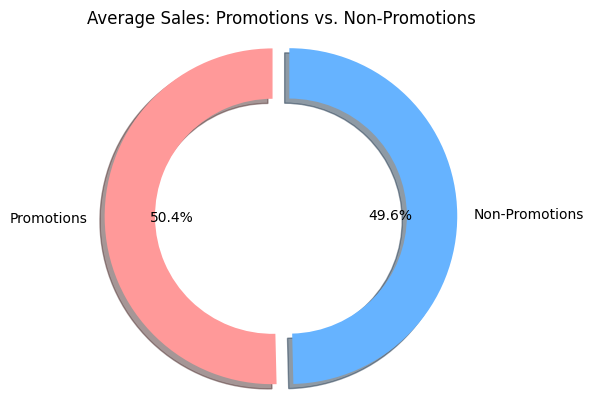

In [18]:
# Create donut plot
labels = promotion_sales_comparison_df['Condition']
sizes = promotion_sales_comparison_df['Average Sales']
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the first slice (Holidays)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops=dict(width=0.3))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Average Sales: Promotions vs. Non-Promotions')
plt.show()

### Influence of Sales by the the day of the week:

Identifying the patterns in sales across days of the week to optimize promotional activity.

In [19]:
# Group sales by day of the week
day_of_week_sales = df.groupby('DayOfWeek')['Monthly Sales'].mean()

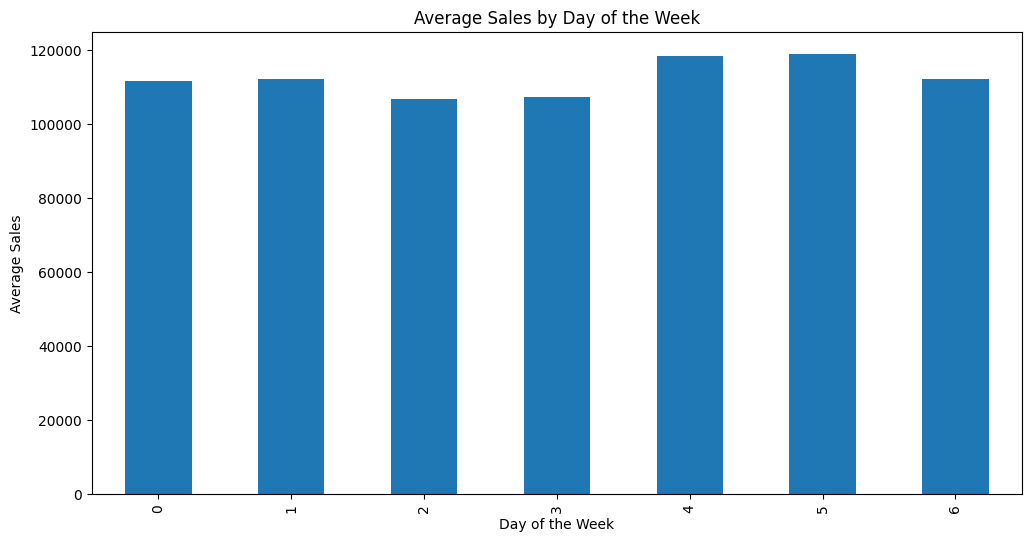

In [20]:
# Plot sales by day of the week
plt.figure(figsize=(12, 6))
day_of_week_sales.plot(kind='bar')
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")
plt.show()

### Analysis of Sales Distribution
Checking for the distribution of monthly sales to understand its spread and identify any outliers.

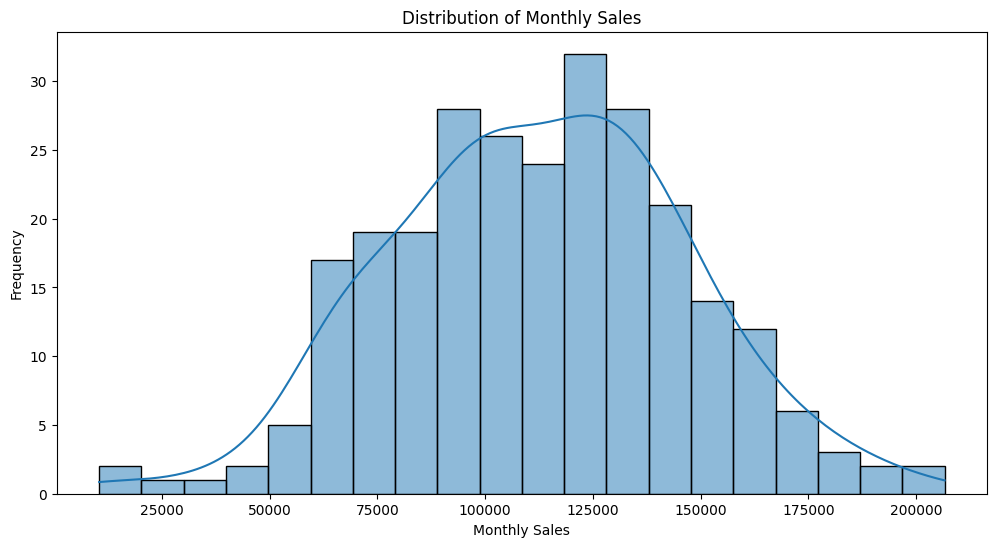

In [21]:
# Plot distribution of monthly sales
plt.figure(figsize=(12, 6))
sns.histplot(df['Monthly Sales'], bins=20, kde=True)
plt.title("Distribution of Monthly Sales")
plt.xlabel("Monthly Sales")
plt.ylabel("Frequency")
plt.show()

###  Sales by Year
Grouping sales by year to see the total and average sales for each year.

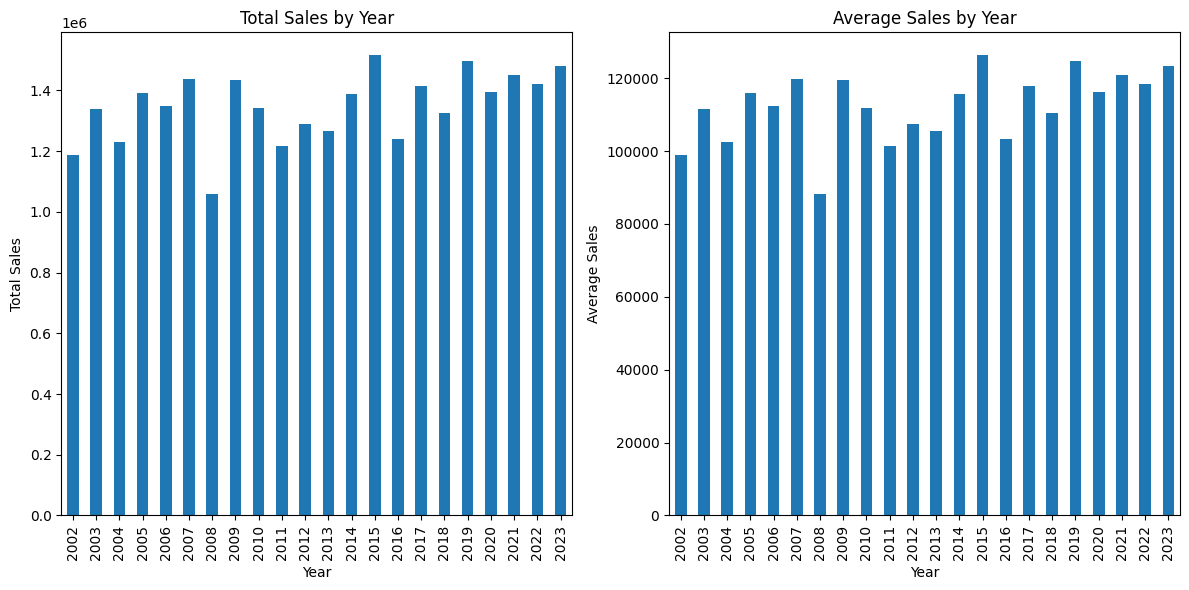

In [22]:
# Group by year and calculate total and average sales
yearly_sales = df.groupby('Year')['Monthly Sales'].agg(['sum', 'mean'])

# Plot yearly sales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
yearly_sales['sum'].plot(kind='bar')
plt.title("Total Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")

plt.subplot(1, 2, 2)
yearly_sales['mean'].plot(kind='bar')
plt.title("Average Sales by Year")
plt.xlabel("Year")
plt.ylabel("Average Sales")

plt.tight_layout()
plt.show()

### Sales by Day of the Week
How sales vary across different days of the week.


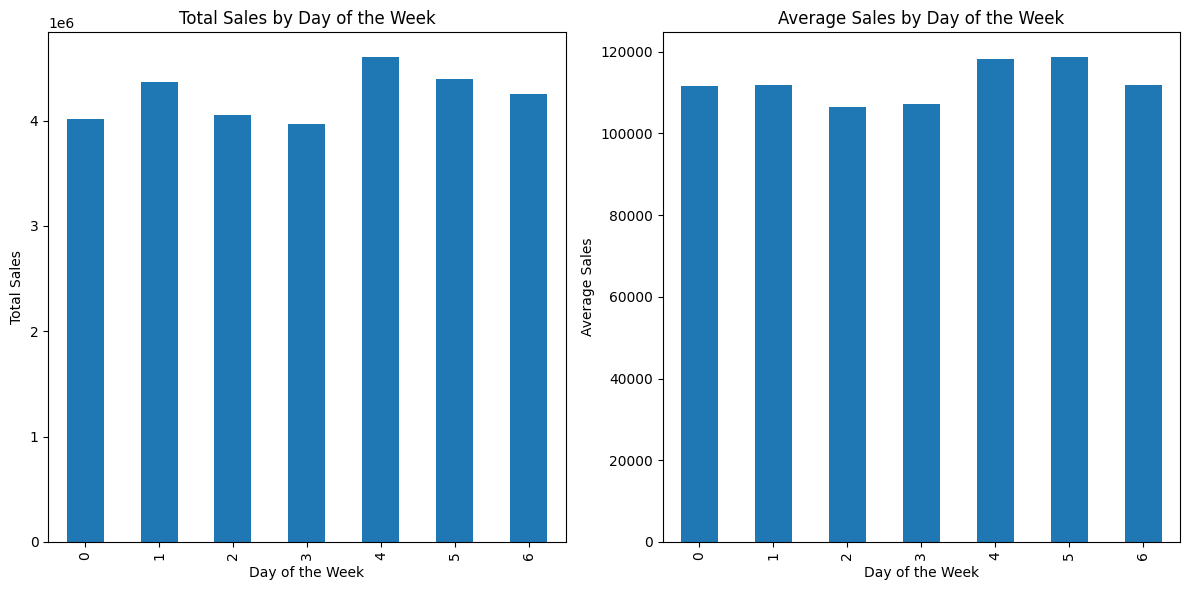

In [23]:
# Group by day of the week and calculate total and average sales
day_of_week_sales = df.groupby('DayOfWeek')['Monthly Sales'].agg(['sum', 'mean'])

# Plot sales by day of the week
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
day_of_week_sales['sum'].plot(kind='bar')
plt.title("Total Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")

plt.subplot(1, 2, 2)
day_of_week_sales['mean'].plot(kind='bar')
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")

plt.tight_layout()
plt.show()

### Sales During Holidays and Promotions
Analysis of how sales are influenced by holidays and promotions.

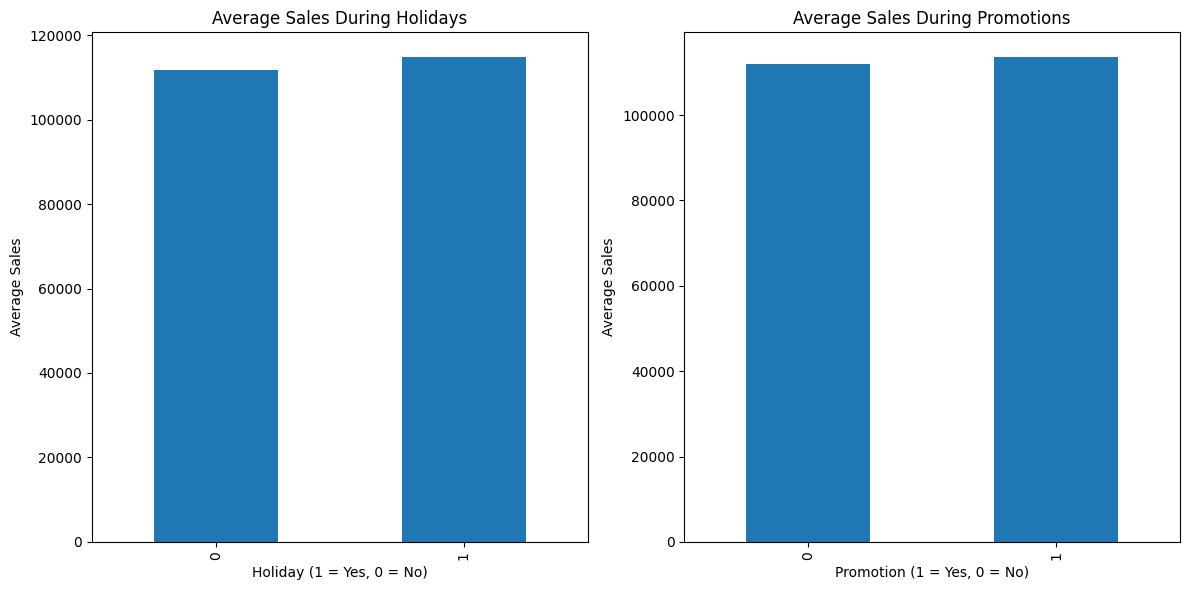

In [24]:
# Group by holiday and calculate total and average sales
holiday_sales = df.groupby('Holiday')['Monthly Sales'].agg(['sum', 'mean'])

# Group by promotion and calculate total and average sales
promotion_sales = df.groupby('Promotion')['Monthly Sales'].agg(['sum', 'mean'])

# Plot sales during holidays and promotions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
holiday_sales['mean'].plot(kind='bar')
plt.title("Average Sales During Holidays")
plt.xlabel("Holiday (1 = Yes, 0 = No)")
plt.ylabel("Average Sales")

plt.subplot(1, 2, 2)
promotion_sales['mean'].plot(kind='bar')
plt.title("Average Sales During Promotions")
plt.xlabel("Promotion (1 = Yes, 0 = No)")
plt.ylabel("Average Sales")

plt.tight_layout()
plt.show()

### Prepare the Data for Correlation Analysis

We’ll encode categorical features (e.g., Holiday, Promotion, Season), focus on numerical features for correlation analysis.

In [25]:
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0
2002-02-28,RPG,129387,2002,4,Nintendo,0,0
2002-03-31,Sports,114777,2002,4,PC,0,0
2002-04-30,Sports,71738,2002,0,Nintendo,0,0
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0


In [26]:
# Encode categorical features
df_encoded = df.copy()
df_encoded['Holiday'] = df_encoded['Holiday'].astype(int)
df_encoded['Promotion'] = df_encoded['Promotion'].astype(int)

# Select all features (numerical + encoded categorical)
all_features = df_encoded[['Monthly Sales', 'Year', 'DayOfWeek', 'Holiday', 'Promotion']]

# Display the first few rows
all_features.head()

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion
Month,,,,,
2002-01-31,108592,2002,1,1,0
2002-02-28,129387,2002,4,0,0
2002-03-31,114777,2002,4,0,0
2002-04-30,71738,2002,0,0,0
2002-05-31,142512,2002,2,0,0


#### Perform Correlation Analysis
Calculate Correlation Matrix

We’ll calculate the Pearson correlation coefficient between all pairs of features.

This measures the linear relationship between variables.

In [27]:
# Calculate correlation matrix
correlation_matrix = all_features.corr()

# Display the correlation matrix
print(correlation_matrix)

               Monthly Sales          Year  DayOfWeek       Holiday  \
Monthly Sales       1.000000  1.346475e-01   0.055444  3.391568e-02   
Year                0.134647  1.000000e+00   0.009144  4.098001e-16   
DayOfWeek           0.055444  9.144262e-03   1.000000  1.786348e-02   
Holiday             0.033916  4.098001e-16   0.017863  1.000000e+00   
Promotion           0.020449 -1.977894e-15   0.025399 -5.039526e-02   

                  Promotion  
Monthly Sales  2.044883e-02  
Year          -1.977894e-15  
DayOfWeek      2.539948e-02  
Holiday       -5.039526e-02  
Promotion      1.000000e+00  


#### Visualizing the Correlation Matrix
Visualize the correlation matrix using a heatmap for better interpretation

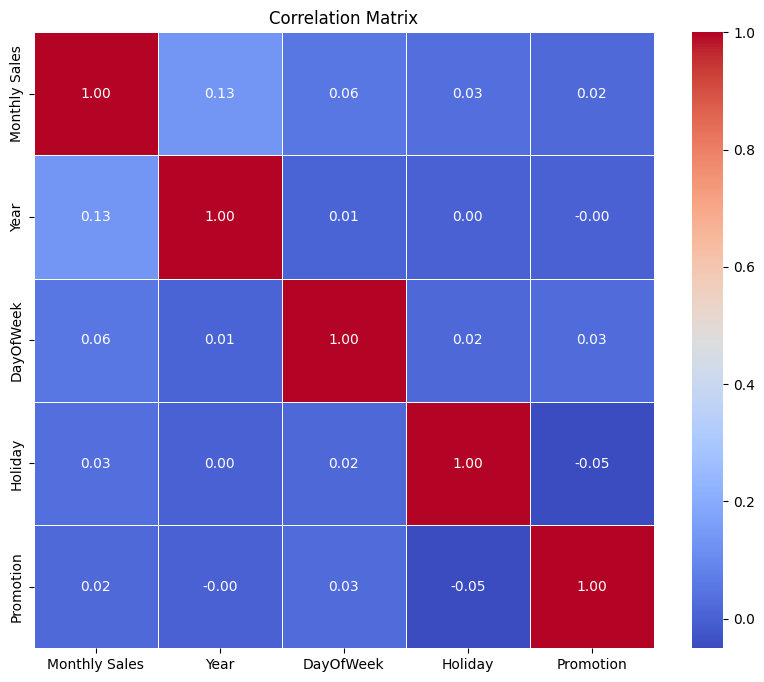

In [28]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Analysis of Correlations with Monthly Sales
Focusing on the correlation between Monthly Sales and other features.

In [29]:
# Extract correlations with Monthly Sales
sales_correlation = correlation_matrix['Monthly Sales'].sort_values(ascending=False)

# Display correlations
print(sales_correlation)

Monthly Sales    1.000000
Year             0.134647
DayOfWeek        0.055444
Holiday          0.033916
Promotion        0.020449
Name: Monthly Sales, dtype: float64


### Key Insights

`Strong Positive Correlation`: Features with a correlation coefficient close to +1 indicate a strong positive relationship with Monthly Sales.

`Strong Negative Correlation`: Features with a correlation coefficient close to -1 indicate a strong negative relationship with Monthly Sales.

`Weak or No Correlation`: Features with a correlation coefficient close to 0 indicate little to no relationship with Monthly Sales.

Note:

If Promotion has a high positive correlation with Monthly Sales, it means promotions are associated with higher sales.

If DayOfWeek has a low correlation with Monthly Sales, it means the day of the week has little impact on sales.

#### Summary of Findings
Trends: Overall sales trends over time (increasing, decreasing, or stable).

Seasonality: Strong seasonal patterns in sales (e.g., higher sales in certain months or seasons).

Holidays and Promotions: Impact of holidays and promotions on sales.

Day of the Week: Variations in sales across days of the week.

New Features: Insights from the "Year-Month" and "Season" features.



#### Next Steps
Feature Engineering: Insights from the correlation analysis will be applied to select and or transform new features (e.g., "Season") in the time series models.

 hence:

  - Include Features: Features with strong correlations (positive or negative) with Monthly Sales.

  - Exclude Features: Features with weak or no correlation with Monthly Sales (unless they have domain importance)

Model Selection: Based on the EDA, appropriate time series models will be selected (e.g., ARIMA, Holt-Winters).

Model Implementation: Based on findings, Select and implement models. Selected Models will be Implemented and tuned.
  - Fine-Tune Models: Experiment with hyperparameters (e.g., ARIMA orders, seasonal periods).

Validate Models: Models will be Evaluated on a test set.

Forecasting: The best model will be used to make future sales forecasts.

## Encoding Categorical Features

Since the dataset includes categorical variables (Category, Platform, Holiday, Promotion), we need to encode them before feeding them into the models.

### Encoding Techniques

- **One-Hot Encoding (OHE)**: Suitable for nominal categorical variables (e.g., Category, Platform).
- **Label Encoding**: Used for binary variables (Holiday, Promotion).

### Implementation of Encoding

In [30]:
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0
2002-02-28,RPG,129387,2002,4,Nintendo,0,0
2002-03-31,Sports,114777,2002,4,PC,0,0
2002-04-30,Sports,71738,2002,0,Nintendo,0,0
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2002-01-31 to 2023-12-31
Freq: ME
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       264 non-null    object
 1   Monthly Sales  264 non-null    int64 
 2   Year           264 non-null    int64 
 3   DayOfWeek      264 non-null    int64 
 4   Platform       264 non-null    object
 5   Holiday        264 non-null    int64 
 6   Promotion      264 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 16.5+ KB


In [32]:
# Convert categorical variables to category dtype
df["Category"] = df["Category"].astype("category")
df["Platform"] = df["Platform"].astype("category")

In [33]:
df.head()

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-31,Sports,108592,2002,1,Xbox,1,0
2002-02-28,RPG,129387,2002,4,Nintendo,0,0
2002-03-31,Sports,114777,2002,4,PC,0,0
2002-04-30,Sports,71738,2002,0,Nintendo,0,0
2002-05-31,Simulation,142512,2002,2,PlayStation,0,0


In [34]:
# Apply one-hot encoding
df = pd.get_dummies(df, columns=["Category", "Platform"], drop_first=True)
df.head()

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion,Category_FPS,Category_RPG,Category_Simulation,Category_Sports,Platform_PC,Platform_PlayStation,Platform_Xbox
Month,,,,,,,,,,,,
2002-01-31,108592,2002,1,1,0,False,False,False,True,False,False,True
2002-02-28,129387,2002,4,0,0,False,True,False,False,False,False,False
2002-03-31,114777,2002,4,0,0,False,False,False,True,True,False,False
2002-04-30,71738,2002,0,0,0,False,False,False,True,False,False,False
2002-05-31,142512,2002,2,0,0,False,False,True,False,False,True,False


In [35]:

# Encode binary categorical variables
df["Holiday"] = df["Holiday"].astype(int)
df["Promotion"] = df["Promotion"].astype(int)


In [36]:
df.head()

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion,Category_FPS,Category_RPG,Category_Simulation,Category_Sports,Platform_PC,Platform_PlayStation,Platform_Xbox
Month,,,,,,,,,,,,
2002-01-31,108592,2002,1,1,0,False,False,False,True,False,False,True
2002-02-28,129387,2002,4,0,0,False,True,False,False,False,False,False
2002-03-31,114777,2002,4,0,0,False,False,False,True,True,False,False
2002-04-30,71738,2002,0,0,0,False,False,False,True,False,False,False
2002-05-31,142512,2002,2,0,0,False,False,True,False,False,True,False


###  Feature Engineering

Create Lag Features & Rolling Statistics

To help models capture historical trends:

In [37]:
df["Lag_1"] = df["Monthly Sales"].shift(1)
df["Lag_2"] = df["Monthly Sales"].shift(2)
df["Rolling_Mean_3"] = df["Monthly Sales"].rolling(window=3).mean()
df.dropna(inplace=True)

In [38]:
df.head()

,Monthly Sales,Year,DayOfWeek,Holiday,Promotion,Category_FPS,Category_RPG,Category_Simulation,Category_Sports,Platform_PC,Platform_PlayStation,Platform_Xbox,Lag_1,Lag_2,Rolling_Mean_3
Month,,,,,,,,,,,,,,,
2002-03-31,114777,2002,4,0,0,False,False,False,True,True,False,False,129387.0,108592.0,117585.333333
2002-04-30,71738,2002,0,0,0,False,False,False,True,False,False,False,114777.0,129387.0,105300.666667
2002-05-31,142512,2002,2,0,0,False,False,True,False,False,True,False,71738.0,114777.0,109675.666667
2002-06-30,100567,2002,5,0,0,False,True,False,False,False,False,True,142512.0,71738.0,104939.000000
2002-07-31,63758,2002,0,0,1,False,False,True,False,False,False,True,100567.0,142512.0,102279.000000


## Model Training & Performance Evaluation

### Train-Test Split


In [39]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

### ARIMA

To fit the ARIMA model and make predictions, there is need to determine the values of p, d 
and q parameters. 

Check the Autocorrelation (ACF) and the Partial Auto-Correlation Function (PACF), plots

<Figure size 1200x600 with 0 Axes>

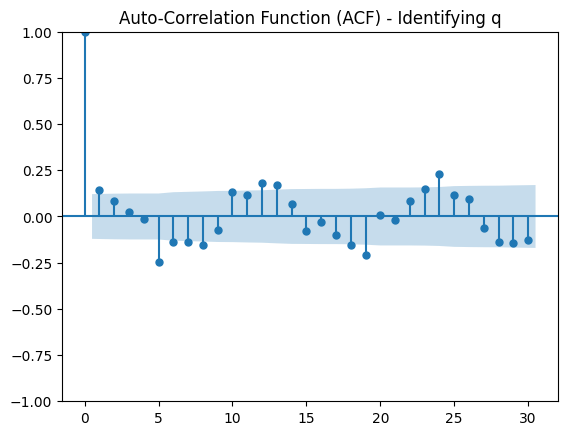

In [40]:
# Plot ACF to find q (MA component)
plt.figure(figsize=(12, 6))
plot_acf(df["Monthly Sales"], lags=30)
plt.title("Auto-Correlation Function (ACF) - Identifying q")
plt.show()


<Figure size 1200x600 with 0 Axes>

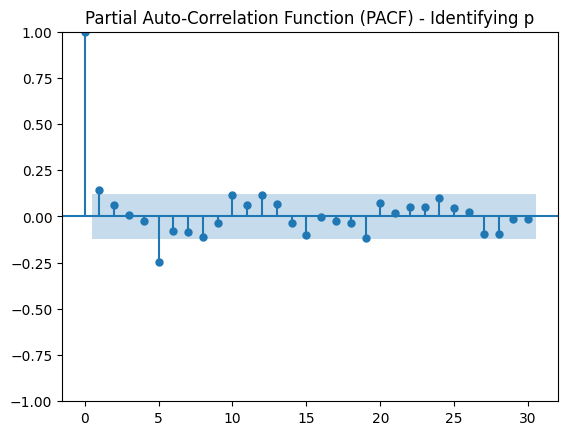

In [41]:
# Plot PACF to find p (AR component)
plt.figure(figsize=(12, 6))
plot_pacf(df["Monthly Sales"], lags=30)
plt.title("Partial Auto-Correlation Function (PACF) - Identifying p")
plt.show()

### Interpreting ACF & PACF Plots for Determining p and q

#### From the PACF plot (Identifying p):
        - The first lag (lag 1) has a strong positive spike.
        - The values cut off sharply after lag 1 (remaining lags are within the confidence interval).
        - This suggests p = 1 for the AR (Auto-Regressive) component.
        - From the ACF plot (Identifying q):

#### The ACF also cuts off after lag 1, meaning that the q value is also 1 for the MA (Moving Average) component.
        - Final ARIMA Order Based on Plots
        - p = 1 (from PACF cutoff)
        - d = 0 (since data is already stationary)
        - q = 1 (from ACF cutoff)

Therefore, the best model to start with is ARIMA(1,0,1).

In [42]:
# Fit the ARIMA model
arima_model = ARIMA(train["Monthly Sales"], order=(1, 0, 1)).fit()


In [43]:
# Forecast the next 4 months
arima_forecast = arima_model.forecast(steps=4)

In [44]:
# Forecast next 4 months
forecast_steps = 4
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
arima_forecast = arima_model.forecast(steps=forecast_steps)

# Convert forecast to DataFrame
arima_forecast = pd.DataFrame({"Month": future_dates, "ARIMA(1,0,1) Forecasted Sales": arima_forecast.values})
arima_forecast.set_index("Month", inplace=True)

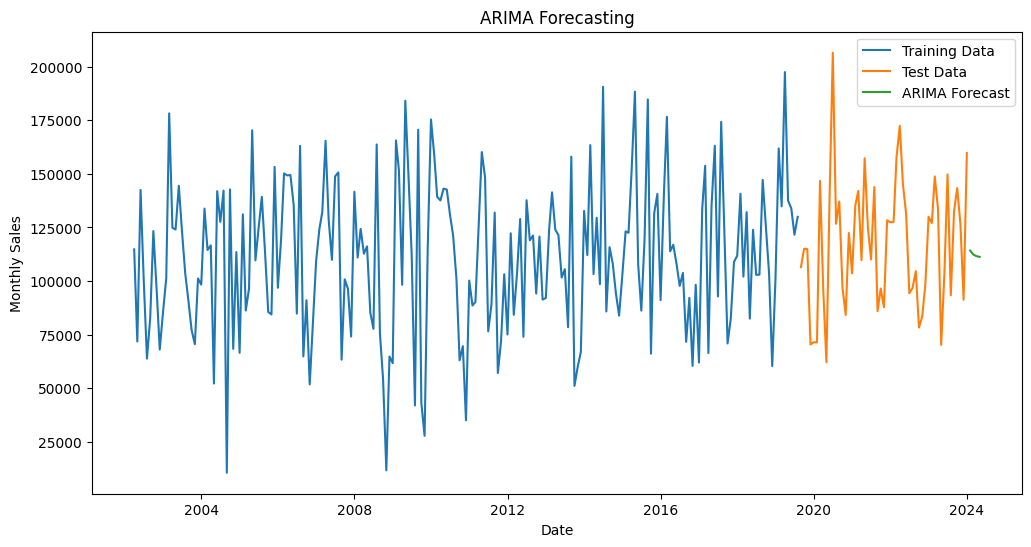

In [45]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Monthly Sales'], label="Training Data")
plt.plot(test['Monthly Sales'], label="Test Data")
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecasting")
plt.xlabel("Date")
plt.ylabel("Monthly Sales")
plt.legend()
plt.show()

In [46]:

print("\n4-Month ARIMA Forecast:")
print(arima_forecast)


4-Month ARIMA Forecast:
            ARIMA(1,0,1) Forecasted Sales
Month                                    
2024-02-01                  114195.887576
2024-03-01                  112383.024143
2024-04-01                  111601.699070
2024-05-01                  111264.956181


###  Exponential Smoothing (ETS Model), Holt-Winters (Additive and Multiplicative)

In [47]:
# Fit the ETS(A,A,A) model
ets_model = ExponentialSmoothing(df["Monthly Sales"], trend="add", seasonal="add", seasonal_periods=12).fit()

In [48]:
# Forecast the next 4 months
forecast_steps = 4
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
ets_forecast = ets_model.forecast(steps=forecast_steps)

In [49]:
# Create a DataFrame to hold both actual and forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Sales": ets_forecast
}).set_index("Date")

# Concatenate actual and forecasted data
combined_df = pd.concat([df["Monthly Sales"], forecast_df["Forecasted Sales"]])


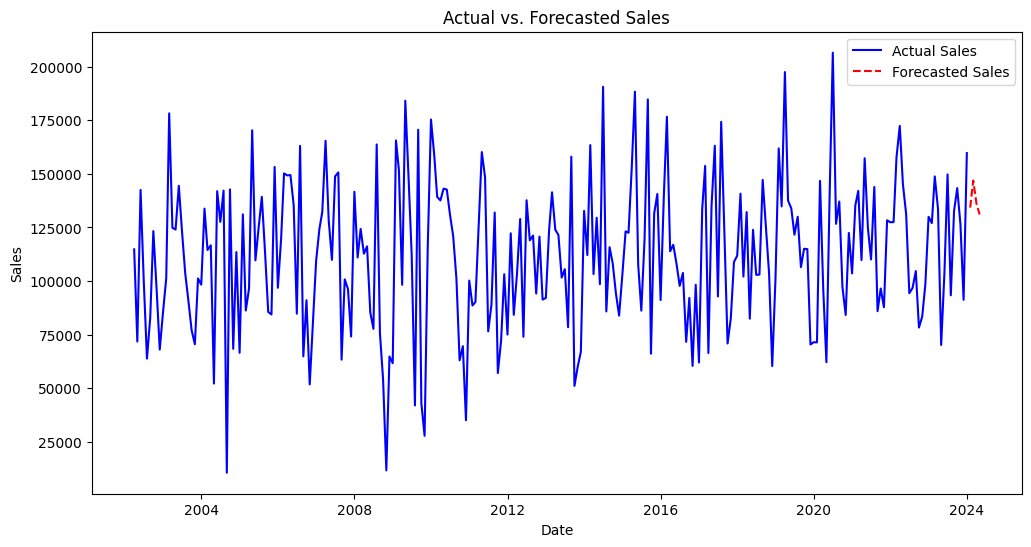

In [50]:
# Plot actual vs. forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Monthly Sales"], label="Actual Sales", color ='blue')
plt.plot(forecast_df.index, forecast_df["Forecasted Sales"], label="Forecasted Sales", linestyle='--', color='red')
plt.title("Actual vs. Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
#plt.grid(True)
plt.show()

In [51]:
# Display forecast
print("\n4-Month ETS Forecast:")
print(ets_forecast)


4-Month ETS Forecast:
2024-01-31    134265.105756
2024-02-29    146922.015311
2024-03-31    136095.825337
2024-04-30    131058.548588
Freq: ME, dtype: float64


### Single Exponential Smoothing (SES)

SES is a simple model that uses a weighted average of past observations.

In [52]:
# Fit the SES model (Simple Exponential Smoothing)
ses_model = SimpleExpSmoothing(df["Monthly Sales"]).fit(smoothing_level=0.2, optimized=True)

In [53]:
# Forecast the next 4 months
forecast_steps = 4
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
ses_forecast = ses_model.forecast(steps=forecast_steps)

In [54]:
# Create a DataFrame to hold both actual and forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Sales": ses_forecast
}).set_index("Date")

# Concatenate actual and forecasted data for plotting
combined_df = pd.concat([df["Monthly Sales"], forecast_df["Forecasted Sales"]])

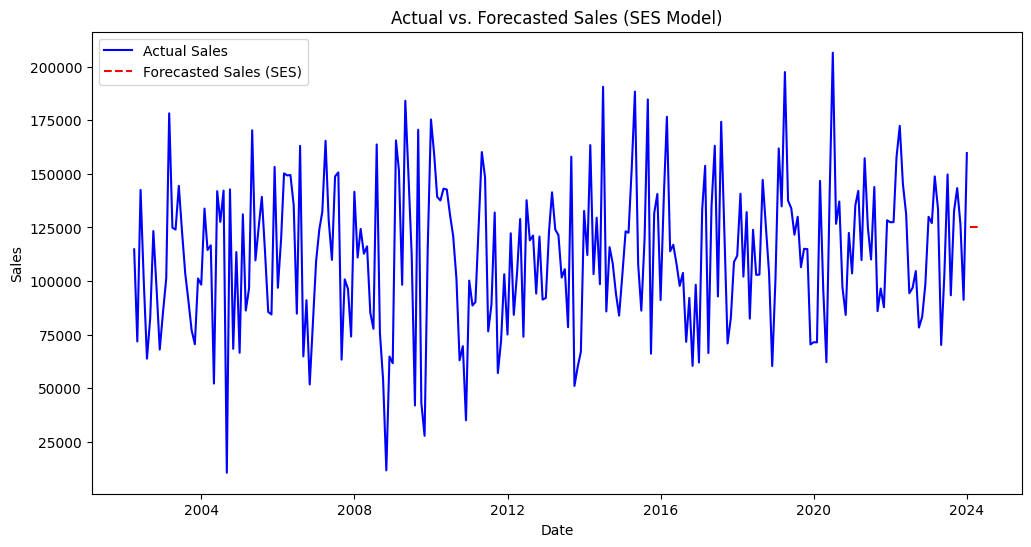

In [55]:
# Plot actual vs. forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Monthly Sales"], label="Actual Sales", color='blue')
plt.plot(forecast_df.index, forecast_df["Forecasted Sales"], label="Forecasted Sales (SES)", linestyle='--', color='red')
plt.title("Actual vs. Forecasted Sales (SES Model)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
#plt.grid(True)
plt.show()

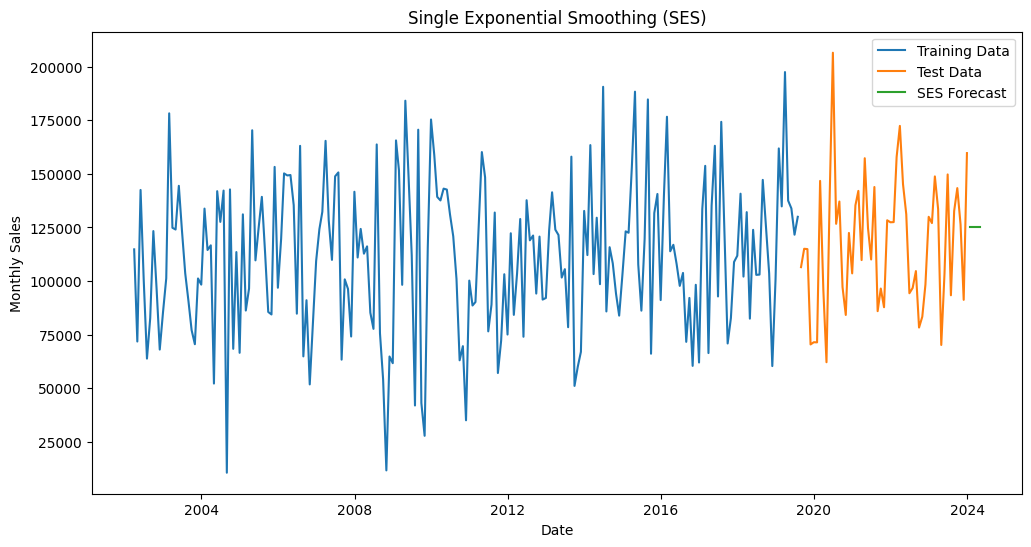

In [56]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['Monthly Sales'], label="Training Data")
plt.plot(test['Monthly Sales'], label="Test Data")
plt.plot(ses_forecast, label="SES Forecast")
plt.title("Single Exponential Smoothing (SES)")
plt.xlabel("Date")
plt.ylabel("Monthly Sales")
plt.legend()
plt.show()

### SARIMA Model and Plot Actual vs. Forecasted Sales

In [57]:
# Fit the SARIMA model
sarima_model = SARIMAX(df["Monthly Sales"], 
                       order=(1, 1, 1),  # Non-seasonal ARIMA(p, d, q)
                       seasonal_order=(1, 1, 1, 12)  # Seasonal ARIMA(P, D, Q, s)
                      ).fit()

In [58]:
# Forecast the next 4 months
forecast_steps = 4
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
sarima_forecast = sarima_model.get_forecast(steps=forecast_steps).predicted_mean

In [59]:
# Create a DataFrame to hold both actual and forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Sales": sarima_forecast.values
}).set_index("Date")

In [60]:
# Concatenate actual and forecasted data for plotting
combined_df = pd.concat([df["Monthly Sales"], forecast_df["Forecasted Sales"]])

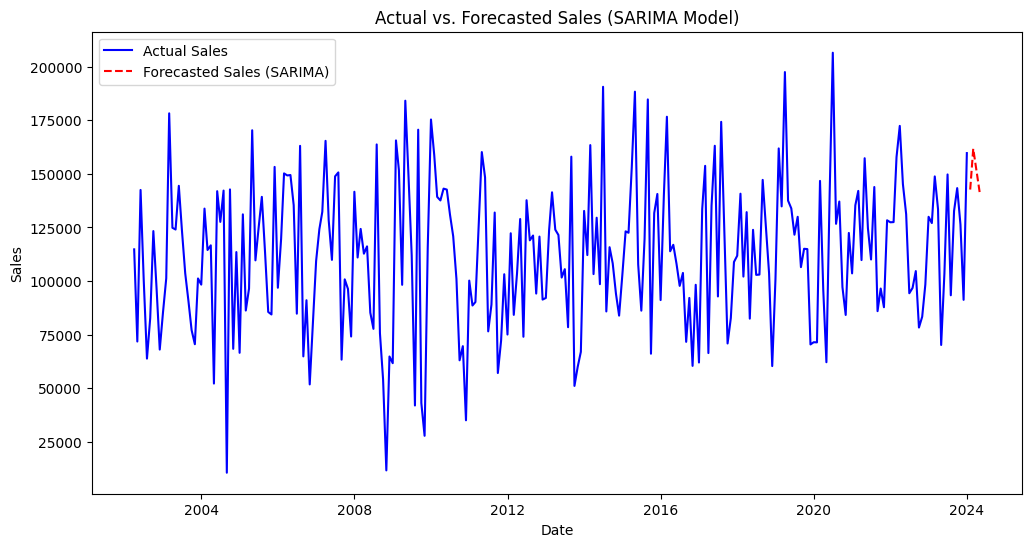

In [61]:
# Plot actual vs. forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Monthly Sales"], label="Actual Sales", color='blue')
plt.plot(forecast_df.index, forecast_df["Forecasted Sales"], label="Forecasted Sales (SARIMA)", linestyle='--', color='red')
plt.title("Actual vs. Forecasted Sales (SARIMA Model)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
#plt.grid()
plt.show()

### # Forecast next 4 months using both all models

In [62]:
# Parameters
forecast_steps = 4
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

In [63]:
# Fit ETS (Exponential Smoothing) Model
ets_model = ExponentialSmoothing(df["Monthly Sales"], trend="add", seasonal="add", seasonal_periods=12).fit()
ets_forecast = ets_model.forecast(steps=forecast_steps)

In [64]:
# Fit ARIMA Model
arima_model = ARIMA(df["Monthly Sales"], order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=forecast_steps)

In [65]:
# Fit SES (Simple Exponential Smoothing) Model
ses_model = SimpleExpSmoothing(df["Monthly Sales"]).fit(smoothing_level=0.2, optimized=True)
ses_forecast = ses_model.forecast(steps=forecast_steps)

In [66]:
# Fit SARIMA Model
sarima_model = SARIMAX(df["Monthly Sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.get_forecast(steps=forecast_steps).predicted_mean

In [67]:
# Convert forecasts to DataFrames
ets_forecast_df = pd.DataFrame({"Month": future_dates, "ETS Forecasted Sales": ets_forecast.values}).set_index("Month")
arima_forecast_df = pd.DataFrame({"Month": future_dates, "ARIMA Forecasted Sales": arima_forecast.values}).set_index("Month")
ses_forecast_df = pd.DataFrame({"Month": future_dates, "SES Forecasted Sales": ses_forecast.values}).set_index("Month")
sarima_forecast_df = pd.DataFrame({"Month": future_dates, "SARIMA Forecasted Sales": sarima_forecast.values}).set_index("Month")

In [68]:
# Merge forecasts for comparison
forecast_comparison_df = ets_forecast_df.merge(arima_forecast_df, left_index=True, right_index=True)
forecast_comparison_df = forecast_comparison_df.merge(ses_forecast_df, left_index=True, right_index=True)
forecast_comparison_df = forecast_comparison_df.merge(sarima_forecast_df, left_index=True, right_index=True)

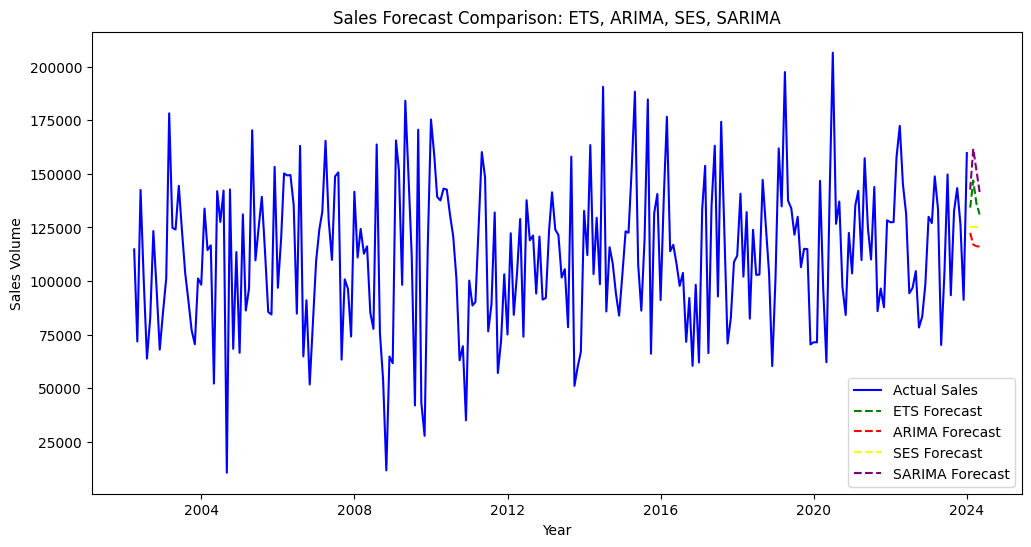

In [69]:
# Plot actual vs. forecasted sales
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(df.index, df["Monthly Sales"], label="Actual Sales", color="blue")

# Plot forecasts from each model
plt.plot(ets_forecast_df.index, ets_forecast_df["ETS Forecasted Sales"], label="ETS Forecast", color="green", linestyle="dashed")
plt.plot(arima_forecast_df.index, arima_forecast_df["ARIMA Forecasted Sales"], label="ARIMA Forecast", color="red", linestyle="dashed")
plt.plot(ses_forecast_df.index, ses_forecast_df["SES Forecasted Sales"], label="SES Forecast", color="yellow", linestyle="dashed")
plt.plot(sarima_forecast_df.index, sarima_forecast_df["SARIMA Forecasted Sales"], label="SARIMA Forecast", color="purple", linestyle="dashed")

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Sales Volume")
plt.title("Sales Forecast Comparison: ETS, ARIMA, SES, SARIMA")
plt.legend()
#plt.grid(True)
plt.show()

In [70]:
# Display forecast comparison
print("\nForecast Comparison (Next 4 Months):")
print(forecast_comparison_df)


Forecast Comparison (Next 4 Months):
            ETS Forecasted Sales  ARIMA Forecasted Sales  \
Month                                                      
2024-02-01         134265.105756           122442.314537   
2024-03-01         146922.015311           117011.040918   
2024-04-01         136095.825337           116219.737986   
2024-05-01         131058.548588           116104.450049   

            SES Forecasted Sales  SARIMA Forecasted Sales  
Month                                                      
2024-02-01         125377.613376            142700.005143  
2024-03-01         125377.613376            161781.736061  
2024-04-01         125377.613376            151497.793767  
2024-05-01         125377.613376            141532.883486  


In [71]:
forecast_comparison_df.head()

,ETS Forecasted Sales,ARIMA Forecasted Sales,SES Forecasted Sales,SARIMA Forecasted Sales
Month,,,,
2024-02-01,134265.105756,122442.314537,125377.613376,142700.005143
2024-03-01,146922.015311,117011.040918,125377.613376,161781.736061
2024-04-01,136095.825337,116219.737986,125377.613376,151497.793767
2024-05-01,131058.548588,116104.450049,125377.613376,141532.883486


In [72]:

# Compute in-sample errors for ETS model
ets_in_sample_pred = ets_model.fittedvalues
ets_mse = mean_squared_error(df["Monthly Sales"], ets_in_sample_pred)
ets_rmse = np.sqrt(ets_mse)  # Root Mean Squared Error
ets_mae = mean_absolute_error(df["Monthly Sales"], ets_in_sample_pred)
ets_mape = mean_absolute_percentage_error(df["Monthly Sales"], ets_in_sample_pred)
ets_r2 = r2_score(df["Monthly Sales"], ets_in_sample_pred)

# Compute in-sample errors for ARIMA model
arima_in_sample_pred = arima_model.fittedvalues
arima_mse = mean_squared_error(df["Monthly Sales"], arima_in_sample_pred)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(df["Monthly Sales"], arima_in_sample_pred)
arima_mape = mean_absolute_percentage_error(df["Monthly Sales"], arima_in_sample_pred)
arima_r2 = r2_score(df["Monthly Sales"], arima_in_sample_pred)

# Compute in-sample errors for SES model
ses_in_sample_pred = ses_model.fittedvalues
ses_mse = mean_squared_error(df["Monthly Sales"], ses_in_sample_pred)
ses_rmse = np.sqrt(ses_mse)
ses_mae = mean_absolute_error(df["Monthly Sales"], ses_in_sample_pred)
ses_mape = mean_absolute_percentage_error(df["Monthly Sales"], ses_in_sample_pred)
ses_r2 = r2_score(df["Monthly Sales"], ses_in_sample_pred)

# Compute in-sample errors for SARIMA model
sarima_in_sample_pred = sarima_model.fittedvalues
sarima_mse = mean_squared_error(df["Monthly Sales"], sarima_in_sample_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(df["Monthly Sales"], sarima_in_sample_pred)
sarima_mape = mean_absolute_percentage_error(df["Monthly Sales"], sarima_in_sample_pred)
sarima_r2 = r2_score(df["Monthly Sales"], sarima_in_sample_pred)

# Create DataFrame to compare in-sample errors
in_sample_errors = pd.DataFrame({
    "Model": ["ETS", "ARIMA", "SES", "SARIMA"],
    "MSE": [ets_mse, arima_mse, ses_mse, sarima_mse],
    "RMSE": [ets_rmse, arima_rmse, ses_rmse, sarima_rmse],
    "MAE": [ets_mae, arima_mae, ses_mae, sarima_mae],
    "MAPE": [ets_mape, arima_mape, ses_mape, sarima_mape],
    "R2 Score": [ets_r2, arima_r2, ses_r2, sarima_r2]
})

# Display in-sample error comparison
print("\nIn-Sample Error Comparison:")
print(in_sample_errors)


In-Sample Error Comparison:
    Model           MSE          RMSE           MAE      MAPE  R2 Score
0     ETS  1.051364e+09  32424.747528  24908.279023  0.303139  0.100737
1   ARIMA  1.234454e+09  35134.796767  27871.646534  0.341305 -0.055865
2     SES  1.287590e+09  35883.001308  28842.722816  0.359954 -0.101314
3  SARIMA  1.318535e+09  36311.632664  28807.503002  0.347233 -0.127782


In [73]:
in_sample_errors.head()

,Model,MSE,RMSE,MAE,MAPE,R2 Score
0,ETS,1.051364e+09,32424.747528,24908.279023,0.303139,0.100737
1,ARIMA,1.234454e+09,35134.796767,27871.646534,0.341305,-0.055865
2,SES,1.287590e+09,35883.001308,28842.722816,0.359954,-0.101314
3,SARIMA,1.318535e+09,36311.632664,28807.503002,0.347233,-0.127782


In [74]:
# Compute holdout sample errors (next 4 months forecasts)
ets_holdout_mse = mean_squared_error(df["Monthly Sales"].iloc[-forecast_steps:], ets_forecast.values)
ets_holdout_rmse = np.sqrt(ets_holdout_mse)
ets_holdout_mae = mean_absolute_error(df["Monthly Sales"].iloc[-forecast_steps:], ets_forecast.values)
ets_holdout_mape = mean_absolute_percentage_error(df["Monthly Sales"].iloc[-forecast_steps:], ets_forecast.values)
ets_holdout_r2 = r2_score(df["Monthly Sales"].iloc[-forecast_steps:], ets_forecast.values)

arima_holdout_mse = mean_squared_error(df["Monthly Sales"].iloc[-forecast_steps:], arima_forecast.values)
arima_holdout_rmse = np.sqrt(arima_holdout_mse)
arima_holdout_mae = mean_absolute_error(df["Monthly Sales"].iloc[-forecast_steps:], arima_forecast.values)
arima_holdout_mape = mean_absolute_percentage_error(df["Monthly Sales"].iloc[-forecast_steps:], arima_forecast.values)
arima_holdout_r2 = r2_score(df["Monthly Sales"].iloc[-forecast_steps:], arima_forecast.values)

ses_holdout_mse = mean_squared_error(df["Monthly Sales"].iloc[-forecast_steps:], ses_forecast.values)
ses_holdout_rmse = np.sqrt(ses_holdout_mse)
ses_holdout_mae = mean_absolute_error(df["Monthly Sales"].iloc[-forecast_steps:], ses_forecast.values)
ses_holdout_mape = mean_absolute_percentage_error(df["Monthly Sales"].iloc[-forecast_steps:], ses_forecast.values)
ses_holdout_r2 = r2_score(df["Monthly Sales"].iloc[-forecast_steps:], ses_forecast.values)

sarima_holdout_mse = mean_squared_error(df["Monthly Sales"].iloc[-forecast_steps:], sarima_forecast.values)
sarima_holdout_rmse = np.sqrt(sarima_holdout_mse)
sarima_holdout_mae = mean_absolute_error(df["Monthly Sales"].iloc[-forecast_steps:], sarima_forecast.values)
sarima_holdout_mape = mean_absolute_percentage_error(df["Monthly Sales"].iloc[-forecast_steps:], sarima_forecast.values)
sarima_holdout_r2 = r2_score(df["Monthly Sales"].iloc[-forecast_steps:], ses_forecast.values)

# Create DataFrame to compare holdout errors
holdout_errors = pd.DataFrame({
    "Model": ["ETS", "ARIMA", "SES", "SARIMA"],
    "MSE": [ets_holdout_mse, arima_holdout_mse, ses_holdout_mse, sarima_holdout_mse],
    "RMSE": [ets_holdout_rmse, arima_holdout_rmse, ses_holdout_rmse, sarima_holdout_rmse],
    "MAE": [ets_holdout_mae, arima_holdout_mae, ses_holdout_mae, sarima_holdout_mae],
    "MAPE": [ets_holdout_mape, arima_holdout_mape, ses_holdout_mape, sarima_holdout_mape],
    "R2 Score": [ets_holdout_r2, arima_holdout_r2, ses_holdout_r2, sarima_holdout_r2]
})

# Display holdout sample error comparison
print("\nHoldout Error Comparison (Next 4 Months):")
print(holdout_errors)

# Determine the best model based on in-sample MAPE
best_model = in_sample_errors.loc[in_sample_errors["MAPE"].idxmin(), "Model"]
print(f"\nThe best model based on in-sample MAPE is: {best_model}")


Holdout Error Comparison (Next 4 Months):
    Model           MSE          RMSE           MAE      MAPE  R2 Score
0     ETS  8.352169e+08  28900.120084  25794.546576  0.224381 -0.294720
1   ARIMA  7.637062e+08  27635.234504  24741.483120  0.191940 -0.183867
2     SES  6.681193e+08  25848.003901  21887.193312  0.180864 -0.035692
3  SARIMA  1.304561e+09  36118.707582  28632.660300  0.264886 -0.035692

The best model based on in-sample MAPE is: ETS


In [75]:
holdout_errors.head()

,Model,MSE,RMSE,MAE,MAPE,R2 Score
0,ETS,8.352169e+08,28900.120084,25794.546576,0.224381,-0.294720
1,ARIMA,7.637062e+08,27635.234504,24741.483120,0.191940,-0.183867
2,SES,6.681193e+08,25848.003901,21887.193312,0.180864,-0.035692
3,SARIMA,1.304561e+09,36118.707582,28632.660300,0.264886,-0.035692


In [76]:
import pickle

# Save ARIMA model
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_model, f)
print("ARIMA model saved as arima_model.pkl")

# Save Holt-Winters (ETS) model
with open("hw_model.pkl", "wb") as f:
    pickle.dump(ets_model, f)
print("Holt-Winters model saved as hw_model.pkl")

# Save SES model
with open("ses_model.pkl", "wb") as f:
    pickle.dump(ses_model, f)
print("SES model saved as ses_model.pkl")

# Save SARIMA model
with open("sarima_model.pkl", "wb") as f:
    pickle.dump(sarima_model, f)
print("SARIMA model saved as sarima_model.pkl")


ARIMA model saved as arima_model.pkl
Holt-Winters model saved as hw_model.pkl
SES model saved as ses_model.pkl
SARIMA model saved as sarima_model.pkl


## Log MlFlow

In [ ]:
# Track using mlflow
import mlflow
import mlflow.sklearn

In [ ]:
# Set MLflow Tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# Set MLflow Experiment Tracking 
mlflow.set_experiment("time_series_forecast")

In [ ]:
# Define forecast steps
forecast_steps = 4

In [ ]:
# ------------------ ETS Model ------------------
# Train ETS model
ets_model = ExponentialSmoothing(df["Monthly Sales"], trend="add", seasonal="add", seasonal_periods=12).fit()

# Extract ETS parameters
alpha = ets_model.params['smoothing_level']
beta = ets_model.params['smoothing_trend']
gamma = ets_model.params['smoothing_seasonal']

# Get in-sample predictions and metrics
ets_pred = ets_model.fittedvalues
ets_mse = mean_squared_error(df["Monthly Sales"], ets_pred)
ets_mae = mean_absolute_error(df["Monthly Sales"], ets_pred)
ets_mape = mean_absolute_percentage_error(df["Monthly Sales"], ets_pred)

# Log ETS model in MLflow
with mlflow.start_run(run_name="ETS_Model"):
    mlflow.log_param("Model", "ETS")
    mlflow.log_param("Alpha", alpha)
    mlflow.log_param("Beta", beta)
    mlflow.log_param("Gamma", gamma)

    mlflow.log_metric("MSE", ets_mse)
    mlflow.log_metric("MAE", ets_mae)
    mlflow.log_metric("MAPE", ets_mape)

    mlflow.sklearn.log_model(ets_model, "ETS_Model")

print("ETS Model logged in MLflow.")

In [ ]:
# ------------------ ARIMA Model ------------------
# Define ARIMA parameters (example: p=1, d=1, q=1)
p, d, q = 1, 1, 1
arima_model = ARIMA(df["Monthly Sales"], order=(p, d, q)).fit()

# Get in-sample predictions and metrics
arima_pred = arima_model.fittedvalues
arima_mse = mean_squared_error(df["Monthly Sales"], arima_pred)
arima_mae = mean_absolute_error(df["Monthly Sales"], arima_pred)
arima_mape = mean_absolute_percentage_error(df["Monthly Sales"], arima_pred)

# Log ARIMA model in MLflow
with mlflow.start_run(run_name="ARIMA_Model"):
    mlflow.log_param("p", p)
    mlflow.log_param("d", d)
    mlflow.log_param("q", q)

    mlflow.log_metric("MSE", arima_mse)
    mlflow.log_metric("MAE", arima_mae)
    mlflow.log_metric("MAPE", arima_mape)

    mlflow.sklearn.log_model(arima_model, "ARIMA_Model")

print("ARIMA Model logged in MLflow.")

In [ ]:
# ------------------ SES Model ------------------
# Train SES model
ses_model = SimpleExpSmoothing(df["Monthly Sales"]).fit(smoothing_level=0.2, optimized=True)

# Get in-sample predictions and metrics
ses_pred = ses_model.fittedvalues
ses_mse = mean_squared_error(df["Monthly Sales"], ses_pred)
ses_mae = mean_absolute_error(df["Monthly Sales"], ses_pred)
ses_mape = mean_absolute_percentage_error(df["Monthly Sales"], ses_pred)

# Log SES model in MLflow
with mlflow.start_run(run_name="SES_Model"):
    mlflow.log_param("Model", "SES")
    mlflow.log_param("Smoothing Level", ses_model.params["smoothing_level"])

    mlflow.log_metric("MSE", ses_mse)
    mlflow.log_metric("MAE", ses_mae)
    mlflow.log_metric("MAPE", ses_mape)

    mlflow.sklearn.log_model(ses_model, "SES_Model")

print("SES Model logged in MLflow.")

In [ ]:
# ------------------ SARIMA Model ------------------
# Train SARIMA model
sarima_model = SARIMAX(df["Monthly Sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Get in-sample predictions and metrics
sarima_pred = sarima_model.fittedvalues
sarima_mse = mean_squared_error(df["Monthly Sales"], sarima_pred)
sarima_mae = mean_absolute_error(df["Monthly Sales"], sarima_pred)
sarima_mape = mean_absolute_percentage_error(df["Monthly Sales"], sarima_pred)

# Log SARIMA model in MLflow
with mlflow.start_run(run_name="SARIMA_Model"):
    mlflow.log_param("Model", "SARIMA")
    mlflow.log_param("Seasonal Order", "(1, 1, 1, 12)")

    mlflow.log_metric("MSE", sarima_mse)
    mlflow.log_metric("MAE", sarima_mae)
    mlflow.log_metric("MAPE", sarima_mape)

    mlflow.sklearn.log_model(sarima_model, "SARIMA_Model")

print("SARIMA Model logged in MLflow.")
